In [1]:
import numpy as np
from tools.graphs import MGraph, slice_graph, plot_graph, slice_graph_by_value, concatenate_graphs, scale_graph
from tools.plottools import plot1dhist, plot2dhist, plot1d_errorbar_v2, savefig_tofile, setplot_defaultstyle, FIGSIZE_BIG, FIGSIZE_SQUARE, FIGSIZE_MID, FIGSIZE_WID, FONTSIZE, FONTSIZE_MID, plot1d_errorbar, plot1d_step, set_plot_defaultstyle
import pickle
from tools.constants import NUCLEI_CHARGE, ANALYSIS_RANGE_EKIN, ISOTOPES_MASS, ISOTOPES_COLOR, ISO_LABELS
from tools.constants import DETECTOR_COLOR, ISOTOPES
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines 
import matplotlib
from tools.MassFunction import expo_func
from scipy.interpolate import UnivariateSpline
import pickle
from scipy.optimize import curve_fit
from tools.massfit_tools import get_fitpdf_witherr, get_fitpdferrorband
from tools.functions import poly, upoly
import uncertainties
from tools.binnings_collection import fbinning_energy_rebin, get_bin_center, fbinning_energy_Li, kinetic_energy_neculeon_binning
from tools.calculator import calc_rig_from_ekin, calc_ratio_and_err
from tools.constants import ISOTOPES_MASS, ISOTOPES_CHARGE,DETECTOR_LABEL 
from tools.plottools import xaxistitle, xaxis_binning
from tools.histograms import Histogram, WeightedHistogram, plot_histogram_1d, plot_histogram_2d 
import os
from tools.binnings import Binning 
import pandas as pd
from tools.constants import ISOTOPES_MASS, NUCLEI_CHARGE, NUCLEIS, ISOTOPES, ISO_LABELS
import uproot
from tools.utilities import get_spline_from_graph, save_spline_to_file, get_graph_from_spline, get_spline_from_file
from tools.MassFunction_V2 import expo_func                                                                                                                                                                                                       
from tools.massfunction_TofGBLV2 import TofInverseMassFunctionFit                                                                                                                                                                                 
from tools.massfunction_NaFGBLV2 import NaFInverseMassFunctionFit                                                                                                                                                                                 
from tools.massfunction_AglGBLV2 import AglInverseMassFunctionFit 

from tools.jupytertools import *

/home/manbing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


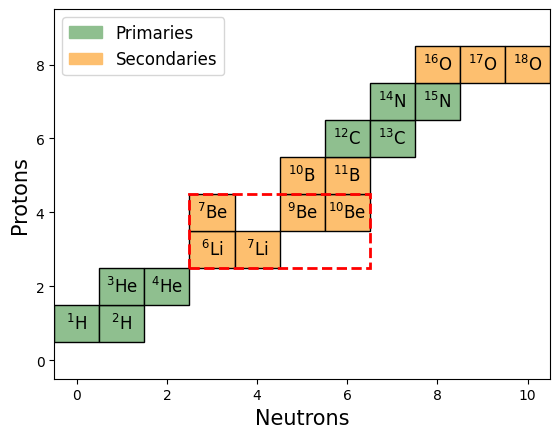

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create a figure and axis with white background
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Define the colors
primary_color = '#8FBF8F'  # light green
secondary_color = '#FDBF6F'  # light orange

# Define the positions and labels for primary and secondary elements
elements = {
    (1, 0): ('H', '1'), (1, 1): ('H', '2'),
    (2, 1): ('He', '3'), (2, 2): ('He', '4'),
    (3, 3): ('Li', '6'), (3, 4): ('Li', '7'),
    (4, 3): ('Be', '7'), (4, 5): ('Be', '9'), (4, 6): ('Be', '10'),
    (5, 5): ('B', '10'), (5, 6): ('B', '11'),
    (6, 6): ('C', '12'), (6, 7): ('C', '13'),
    (7, 7): ('N', '14'), (7, 8): ('N', '15'),
    (8, 8): ('O', '16'), (8, 9): ('O', '17'), (8, 10): ('O', '18')
}

# Plot the elements
for (protons, neutrons), (symbol, mass) in elements.items():
    color = primary_color if symbol in ['H', 'He', 'C', 'N'] else secondary_color
    rect = patches.Rectangle((neutrons-0.5, protons-0.5), 1, 1, linewidth=1, edgecolor='black', facecolor=color)
    ax.add_patch(rect)
    ax.text(neutrons, protons, rf'$\mathrm{{^{{ {mass}}} {symbol}}}$', ha='center', va='center', fontsize=12, color='black')

# Add the dashed rectangle
rect = patches.Rectangle((2.5, 2.5), 4, 2, linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
ax.add_patch(rect)

# Add arrow
#ax.annotate('', xy=(4, 6), xytext=(3.5, 6), arrowprops=dict(facecolor='pink', shrink=0.05))

# Set axis limits and labels
ax.set_xlim(-0.5, 10.5)
ax.set_ylim(-0.5, 9.5)
ax.set_xlabel('Neutrons', fontsize=15)
ax.set_ylabel('Protons', fontsize=15)

# Add legend
primary_patch = patches.Patch(color=primary_color, label='Primaries')
secondary_patch = patches.Patch(color=secondary_color, label='Secondaries')
ax.legend(handles=[primary_patch, secondary_patch], loc='upper left', fontsize=12)

plt.show()
plotdir = '/home/manbing/Documents/Li_Manbing_PhD_Defense/plots'
savefig_tofile(fig, plotdir, f"IsoElement", show=True)


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/Screenshot from 2024-06-19 15-16-12.png'

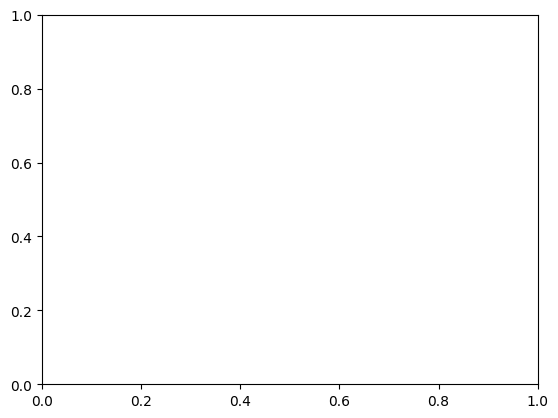

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont

# Create figure and axis
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Load images (supernova, oxygen, carbon, helium, etc.)
supernova_img = Image.open("/mnt/data/Screenshot from 2024-06-19 15-16-12.png")  # Adjust the path accordingly

# Example positions for the elements
elements = [
    {"name": "Supernova", "position": (0.1, 0.6), "img": supernova_img},
    {"name": "Oxygen", "position": (0.4, 0.5), "img": supernova_img},
    {"name": "Carbon", "position": (0.5, 0.5), "img": supernova_img},
    {"name": "Helium", "position": (0.6, 0.5), "img": supernova_img},
    {"name": "Interstellar Medium", "position": (0.5, 0.4)},
    {"name": "7Be", "position": (0.4, 0.3), "img": supernova_img},
    {"name": "10B", "position": (0.5, 0.3), "img": supernova_img},
    {"name": "11B", "position": (0.6, 0.3), "img": supernova_img},
    {"name": "6Li", "position": (0.5, 0.2), "img": supernova_img},
    {"name": "7Li", "position": (0.6, 0.2), "img": supernova_img},
]

# Draw elements
for element in elements:
    if "img" in element:
        ax.imshow(element["img"], extent=(element["position"][0], element["position"][0]+0.1, element["position"][1], element["position"][1]+0.1))
    ax.text(element["position"][0], element["position"][1], element["name"], fontsize=12, ha='center')

# Add annotations and arrows
ax.annotate('Supernova', xy=(0.15, 0.65), xytext=(0.3, 0.8),
            arrowprops=dict(facecolor='blue', shrink=0.05))
ax.annotate('Oxygen', xy=(0.45, 0.55), xytext=(0.3, 0.8),
            arrowprops=dict(facecolor='blue', shrink=0.05))
ax.annotate('Carbon', xy=(0.55, 0.55), xytext=(0.3, 0.8),
            arrowprops=dict(facecolor='blue', shrink=0.05))
ax.annotate('Helium', xy=(0.65, 0.55), xytext=(0.3, 0.8),
            arrowprops=dict(facecolor='blue', shrink=0.05))

# Draw the interstellar medium cloud
cloud = patches.Ellipse((0.5, 0.4), 0.4, 0.1, edgecolor='black', facecolor='lightblue')
ax.add_patch(cloud)
ax.text(0.5, 0.4, "Interstellar Medium", fontsize=12, ha='center', color='blue')

# Adjust the plot limits
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

# Show plot
plt.show()